# Making Animations of UMAP Hyper-parameters

Sometimes one of the best ways to see the effects of hyperparameters is simply to visualise what happens as they change. We can do that in practice with UMAP by simply creating an animation that transitions between embeddings generated with variations of hyperparameters. To do this we'll make use of matplotlib and its animation capabilities. Jake Vanderplas has [a great tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) if you want to know more about creating animations with matplotlib.

To start let's load everything we'll need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import seaborn as sns
import itertools
sns.set(style='white', rc={'figure.figsize':(14, 12)})

In [2]:
from sklearn.datasets import load_digits

In [3]:
from umap import UMAP

To try this out we'll needs a reasonably small dataset (so embedding runs don't take *too* long since we'll be doing a lot of them). For ease of reproducibility for everyone else I'll use the digits dataset from sklearn. If you want to try other datasets just drop them in here -- COIL20 might be interesting, or you might have your own data.

In [4]:
digits = load_digits()
data = digits.data
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

We need to move the points in between the embeddings given by different parameter values. There are potentially fancy ways to do this (Something using rotatio and reflection to get an initial alignment might be interesting), but we'll use straighforward linear interpolation between the two embeddings. To do this we'll need a simple function that can turn out intermediate embeddings for the in-between frames of the animation.

In [5]:
def tween(e1, e2, n_frames=20):
    for i in range(5):
        yield e1
    for i in range(n_frames):
        alpha = i / float(n_frames - 1)
        yield (1 - alpha) * e1 + alpha * e2
    for i in range(5):
        yield(e2)
    return

Now that we can fill in intermediate frame we just need to generate all the embeddings. We'll create a function that can take an argument and set of parameter values and then generate all the embeddings including the in-between frames.

In [6]:
def generate_frame_data(data, arg_name='n_neighbors', arg_list=[3,4,5,7,9,11,15,20,25,30,40,60,100]):
    result = []
    es = []
    for arg in arg_list:
        kwargs = {arg_name:arg}
        if len(es) > 0:
            es.append(UMAP(init=es[-1], negative_sample_rate=3, **kwargs).fit_transform(data))
        else:
            es.append(UMAP(negative_sample_rate=3, **kwargs).fit_transform(data))
        
    for e1, e2 in zip(es[:-1], es[1:]):
        result.extend(list(tween(e1, e2)))
        
    return result

Next we just need to create a function to actually generate the animation given a list of embeddings (one for each frame). This is really just a matter of workign through the details of how matplotlib generates animations -- I would refer you again to Jake's tutorial if you are interested in the detailed mechanics of this.

In [7]:
def create_animation(frame_data, arg_name='n_neighbors', arg_list=[3,4,5,7,9,11,15,20,25,30,40,60,100]):
    fig = plt.figure()
    all_data = np.vstack(frame_data)
    frame_bounds = (all_data[:, 0].min() * 1.1, 
                    all_data[:, 0].max() * 1.1,
                    all_data[:, 1].min() * 1.1, 
                    all_data[:, 1].max() * 1.1)
    ax = plt.axes(xlim=(frame_bounds[0], frame_bounds[1]), 
                  ylim=(frame_bounds[2], frame_bounds[3]))
    points = plt.scatter(frame_data[0][:, 0], frame_data[0][:, 1], 
                        s=5, c=digits.target, cmap='Spectral', animated=True)
    title = plt.title('', fontsize=24)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(values=np.arange(10), boundaries=np.arange(11)-0.5, ticks=np.arange(10), drawedges=True)
    cbar.ax.yaxis.set_ticklabels(np.arange(10), fontsize=18)

    def init():
        points.set_offsets(frame_data[0])
        title.set_text('UMAP with {}={}'.format(arg_name, arg_list[0]))
        return points,

    def animate(i):
        points.set_offsets(frame_data[i])
        if (i + 15) % 30 == 0:
            title.set_text('UMAP with {}={}'.format(arg_name, arg_list[(i + 15) // 30]))
        return points,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_data), interval=20, blit=True)
    anim.save('umap_anim-{}.gif'.format(arg_name), writer='imagemagick', fps=30)

Finally a little bit of glue to make it all go together.

In [8]:
def animate_param(data, arg_name='n_neighbors', arg_list=[3,4,5,7,9,11,15,20,25,30,40,60,100]):
    frame_data = generate_frame_data(data, arg_name, arg_list)
    create_animation(frame_data, arg_name, arg_list)

Now we can create an animation -- it will get saved as a GIF file in the current directory. You'll also get to see the final frame of the animation displayed in the notebook.

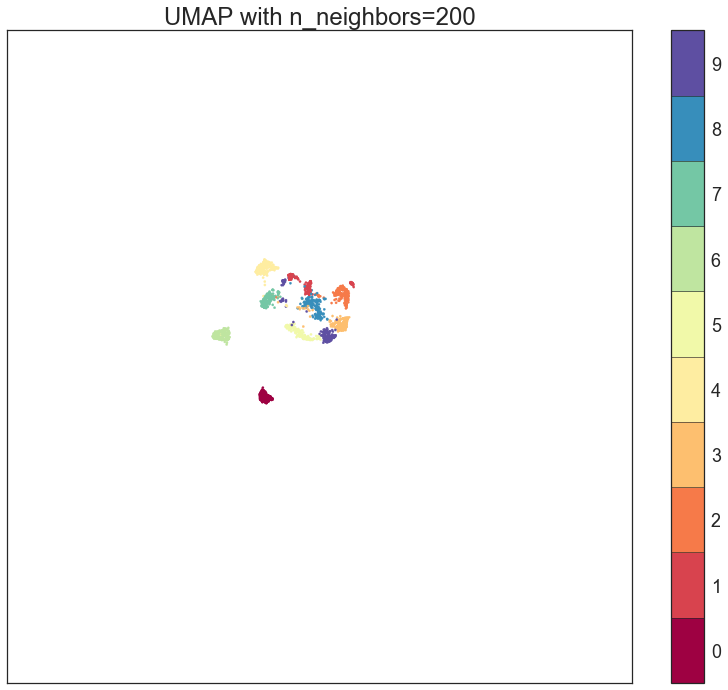

In [9]:
animate_param(data, 'n_neighbors', [3,4,5,7,10,15,25,50,100,200])
#animate_param(data, 'min_dist', [0.0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.9])
#animate_param(data, 'gamma', [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
#animate_param(data, 'local_connectivity', [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
#animate_param(data, 'bandwidth', [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0])
#animate_param(data, 'set_op_mix_ratio', np.linspace(0.0, 1.0, 10))